# Effectsize objects

> The auxiliary classes involved in the computations of bootstrapped effect sizes.

- order: 10

In [ ]:
#| default_exp _effsize_objects

In [ ]:
#| hide
from __future__ import annotations

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev
nbdev.nbdev_export()

In [ ]:
#| hide
import dabest

Pre-compiling numba functions for DABEST...


Compiling numba functions: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]

Numba compilation complete!


In [ ]:
#| export
import pandas as pd
import lqrt
from scipy.stats import norm
import numpy as np
from scipy.special import binom as binomcoeff  # devMJBL
from scipy.stats import binom  # devMJBL
from scipy.integrate import fixed_quad  # devMJBL
from numpy import arange, mean  # devMJBL
from numpy import array, isnan, isinf, repeat, random, isin, abs, var
from numpy import sort as npsort
from numpy import nan as npnan
from numpy.random import PCG64, RandomState
from statsmodels.stats.contingency_tables import mcnemar
import warnings
from string import Template
import scipy.stats as spstats

In [ ]:
#| export
class TwoGroupsEffectSize(object):

    """
    A class to compute and store the results of bootstrapped
    mean differences between two groups.

    Compute the effect size between two groups.

        Parameters
        ----------
        control : array-like
        test : array-like
            These should be numerical iterables.
        effect_size : string.
            Any one of the following are accepted inputs:
            'mean_diff', 'median_diff', 'cohens_d', 'hedges_g', or 'cliffs_delta'
        is_paired : string, default None
        resamples : int, default 5000
            The number of bootstrap resamples to be taken for the calculation
            of the confidence interval limits.
        permutation_count : int, default 5000
            The number of permutations (reshuffles) to perform for the
            computation of the permutation p-value
        ci : float, default 95
            The confidence interval width. The default of 95 produces 95%
            confidence intervals.
        random_seed : int, default 12345
            `random_seed` is used to seed the random number generator during
            bootstrap resampling. This ensures that the confidence intervals
            reported are replicable.
        ps_adjust : boolean, default False.
            If True, adjust calculated p-value according to Phipson & Smyth (2010)
            # https://doi.org/10.2202/1544-6115.1585
            

        Returns
        -------
        A :py:class:`TwoGroupEffectSize` object:
            `difference` : float
                The effect size of the difference between the control and the test.
            `effect_size` : string
                The type of effect size reported.
            `is_paired` : string
                The type of repeated-measures experiment.
            `ci` : float
                Returns the width of the confidence interval, in percent.
            `alpha` : float
                Returns the significance level of the statistical test as a float between 0 and 1.
            `resamples` : int
                The number of resamples performed during the bootstrap procedure.
            `bootstraps` : numpy ndarray
                The generated bootstraps of the effect size.
            `random_seed` : int
                The number used to initialise the numpy random seed generator, ie.`seed_value` from `numpy.random.seed(seed_value)` is returned.
            `bca_low, bca_high` : float
                The bias-corrected and accelerated confidence interval lower limit and upper limits, respectively.
            `pct_low, pct_high` : float
                The percentile confidence interval lower limit and upper limits, respectively.
    """

    def __init__(
        self,
        control,
        test,
        effect_size,
        proportional=False,
        is_paired=None,
        ci=95,
        resamples=5000,
        permutation_count=5000,
        random_seed=12345,
        ps_adjust=False,
    ):
        from ._stats_tools import confint_2group_diff as ci2g
        from ._stats_tools import effsize as es

        self.__EFFECT_SIZE_DICT = {
            "mean_diff": "mean difference",
            "median_diff": "median difference",
            "cohens_d": "Cohen's d",
            "cohens_h": "Cohen's h",
            "hedges_g": "Hedges' g",
            "cliffs_delta": "Cliff's delta",
        }
  
        self.__is_paired = is_paired
        self.__resamples = resamples
        self.__effect_size = effect_size
        self.__random_seed = random_seed
        self.__ci = ci
        self.__is_proportional = proportional
        self.__ps_adjust = ps_adjust
        self._check_errors(control, test)

        # Convert to numpy arrays for speed.
        # NaNs are automatically dropped.
        control = array(control)
        test = array(test)
        self.__control = control[~isnan(control)]
        self.__test = test[~isnan(test)]
        self.__permutation_count = permutation_count

        self.__alpha = ci2g._compute_alpha_from_ci(self.__ci)

        self.__difference = es.two_group_difference(
            self.__control, self.__test, self.__is_paired, self.__effect_size
        )

        self.__jackknives = ci2g.compute_meandiff_jackknife(
            self.__control, self.__test, self.__is_paired, self.__effect_size
        )

        self.__acceleration_value = ci2g._calc_accel(self.__jackknives)

        bootstraps = ci2g.compute_bootstrapped_diff(
            self.__control,
            self.__test,
            self.__is_paired,
            self.__effect_size,
            self.__resamples,
            self.__random_seed,
        )
        self.__bootstraps = bootstraps

        sorted_bootstraps = npsort(self.__bootstraps)
        # Added in v0.2.6.
        # Raises a UserWarning if there are any infiinities in the bootstraps.
        num_infinities = len(self.__bootstraps[isinf(self.__bootstraps)])

        if num_infinities > 0:
            warn_msg = (
                "There are {} bootstrap(s) that are not defined. "
                "This is likely due to smaple sample sizes. "
                "The values in a bootstrap for a group will be more likely "
                "to be all equal, with a resulting variance of zero. "
                "The computation of Cohen's d and Hedges' g thus "
                "involved a division by zero. "
            )
            warnings.warn(warn_msg.format(num_infinities), category=UserWarning)

        self.__bias_correction = ci2g.compute_meandiff_bias_correction(
            self.__bootstraps, self.__difference
        )

        self._compute_bca_intervals(sorted_bootstraps)

        # Compute percentile intervals.
        pct_idx_low = int((self.__alpha / 2) * self.__resamples)
        pct_idx_high = int((1 - (self.__alpha / 2)) * self.__resamples)

        self.__pct_interval_idx = (pct_idx_low, pct_idx_high)
        self.__pct_low = sorted_bootstraps[pct_idx_low]
        self.__pct_high = sorted_bootstraps[pct_idx_high]
        
        self._get_bootstrap_baseline_ec()

        self._perform_statistical_test()

    def __repr__(self, show_resample_count=True, define_pval=True, sigfig=3):
        RM_STATUS = {
            "baseline": "for repeated measures against baseline \n",
            "sequential": "for the sequential design of repeated-measures experiment \n",
            "None": "",
        }

        PAIRED_STATUS = {
            "baseline": "paired",
            "sequential": "paired",
            "None": "unpaired",
        }

        first_line = {
            "rm_status": RM_STATUS[str(self.__is_paired)],
            "es": self.__EFFECT_SIZE_DICT[self.__effect_size],
            "paired_status": PAIRED_STATUS[str(self.__is_paired)],
        }

        out1 = "The {paired_status} {es} {rm_status}".format(**first_line)

        base_string_fmt = "{:." + str(sigfig) + "}"
        if "." in str(self.__ci):
            ci_width = base_string_fmt.format(self.__ci)
        else:
            ci_width = str(self.__ci)

        ci_out = {
            "es": base_string_fmt.format(self.__difference),
            "ci": ci_width,
            "bca_low": base_string_fmt.format(self.__bca_low),
            "bca_high": base_string_fmt.format(self.__bca_high),
        }

        out2 = "is {es} [{ci}%CI {bca_low}, {bca_high}].".format(**ci_out)
        out = out1 + out2

        pval_rounded = base_string_fmt.format(self.pvalue_permutation)

        p1 = "The p-value of the two-sided permutation t-test is {}, ".format(
            pval_rounded
        )
        p2 = "calculated for legacy purposes only. "
        pvalue = p1 + p2

        bs1 = "{} bootstrap samples were taken; ".format(self.__resamples)
        bs2 = "the confidence interval is bias-corrected and accelerated."
        bs = bs1 + bs2

        pval_def1 = (
            "Any p-value reported is the probability of observing the"
            + "effect size (or greater),\nassuming the null hypothesis of "
            + "zero difference is true."
        )
        pval_def2 = (
            "\nFor each p-value, 5000 reshuffles of the "
            + "control and test labels were performed."
        )
        pval_def = pval_def1 + pval_def2

        if show_resample_count and define_pval:
            return "{}\n{}\n\n{}\n{}".format(out, pvalue, bs, pval_def)
        elif not show_resample_count and define_pval:
            return "{}\n{}\n\n{}".format(out, pvalue, pval_def)
        elif show_resample_count and not define_pval:
            return "{}\n{}\n\n{}".format(out, pvalue, bs)
        else:
            return "{}\n{}".format(out, pvalue)

    def _check_errors(self, control, test):
        '''
        Function to check configuration errors for the given control and test data.
        '''
        kosher_es = [a for a in self.__EFFECT_SIZE_DICT.keys()]
        if self.__effect_size not in kosher_es:
            err1 = "The effect size '{}'".format(self.__effect_size)
            err2 = "is not one of {}".format(kosher_es)
            raise ValueError(" ".join([err1, err2]))

        if self.__effect_size == "cliffs_delta" and self.__is_paired:
            err1 = "`paired` is not None; therefore Cliff's delta is not defined."
            raise ValueError(err1)

        if self.__is_proportional and self.__effect_size not in ["mean_diff", "cohens_h"]:
            err1 = "`is_proportional` is True; therefore effect size other than mean_diff and cohens_h is not defined."
            raise ValueError(err1)

        if self.__is_proportional and (
            isin(control, [0, 1]).all() == False or isin(test, [0, 1]).all() == False
        ):
            err1 = (
                "`is_proportional` is True; Only accept binary data consisting of 0 and 1."
            )
            raise ValueError(err1)

    def _compute_bca_intervals(self, sorted_bootstraps):
        '''
        Function to compute the bca intervals given the sorted bootstraps.
        '''
        from ._stats_tools import confint_2group_diff as ci2g

        # Compute BCa intervals.
        bca_idx_low, bca_idx_high = ci2g.compute_interval_limits(
            self.__bias_correction,
            self.__acceleration_value,
            self.__resamples,
            self.__ci,
        )

        self.__bca_interval_idx = (bca_idx_low, bca_idx_high)

        if ~isnan(bca_idx_low) and ~isnan(bca_idx_high):
            self.__bca_low = sorted_bootstraps[bca_idx_low]
            self.__bca_high = sorted_bootstraps[bca_idx_high]

            err1 = "The $lim_type limit of the interval"
            err2 = "was in the $loc 10 values."
            err3 = "The result should be considered unstable."
            err_temp = Template(" ".join([err1, err2, err3]))

            if bca_idx_low <= 10:
                warnings.warn(
                    err_temp.substitute(lim_type="lower", loc="bottom"), stacklevel=1
                )

            if bca_idx_high >= self.__resamples - 9:
                warnings.warn(
                    err_temp.substitute(lim_type="upper", loc="top"), stacklevel=1
                )

        else:
            err1 = "The $lim_type limit of the BCa interval cannot be computed."
            err2 = "It is set to the effect size itself."
            err3 = "All bootstrap values were likely all the same."
            err_temp = Template(" ".join([err1, err2, err3]))

            if isnan(bca_idx_low):
                self.__bca_low = self.__difference
                warnings.warn(err_temp.substitute(lim_type="lower"), stacklevel=0)

            if isnan(bca_idx_high):
                self.__bca_high = self.__difference
                warnings.warn(err_temp.substitute(lim_type="upper"), stacklevel=0)

    def _perform_statistical_test(self):
        '''
        Function to complete the statistical tests
        '''
        from ._stats_tools import effsize as es

        # Perform statistical tests.
        self.__PermutationTest_result = PermutationTest(
            self.__control,
            self.__test,
            self.__effect_size,
            self.__is_paired,
            self.__permutation_count,
            ps_adjust = self.__ps_adjust,
        )

        if self.__is_paired and not self.__is_proportional:
            # Wilcoxon, a non-parametric version of the paired T-test.
            try:
                wilcoxon = spstats.wilcoxon(self.__control, self.__test)
                self.__pvalue_wilcoxon = wilcoxon.pvalue
                self.__statistic_wilcoxon = wilcoxon.statistic
            except ValueError as e:
                warnings.warn("Wilcoxon test could not be performed. This might be due "
                    "to no variability in the difference of the paired groups. \n"
                    "Error: {}\n"
                    "For detailed information, please refer to https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html "
                    .format(e))

            if self.__effect_size != "median_diff":
                # Paired Student's t-test.
                paired_t = spstats.ttest_rel(
                    self.__control, self.__test, nan_policy="omit"
                )
                self.__pvalue_paired_students_t = paired_t.pvalue
                self.__statistic_paired_students_t = paired_t.statistic

        elif self.__is_paired and self.__is_proportional:
            # for binary paired data, use McNemar's test
            # References:
            # https://en.wikipedia.org/wiki/McNemar%27s_test

            x1 = np.sum((self.__control == 0) & (self.__test == 0))
            x2 = np.sum((self.__control == 0) & (self.__test == 1))
            x3 = np.sum((self.__control == 1) & (self.__test == 0))
            x4 = np.sum((self.__control == 1) & (self.__test == 1))
            table = np.array([[x1, x2], [x3, x4]])
            _mcnemar = mcnemar(table, exact=True, correction=True)
            self.__pvalue_mcnemar = _mcnemar.pvalue
            self.__statistic_mcnemar = _mcnemar.statistic

        elif self.__is_proportional:
            # The Cohen's h calculation is for binary categorical data
            try:
                self.__proportional_difference = es.cohens_h(
                    self.__control, self.__test
                )
            except ValueError as e:
                warnings.warn(f"Calculation of Cohen's h failed. This method is applicable "
                  f"only for binary data (0's and 1's). Details: {e}")

        elif self.__effect_size == "cliffs_delta":
            # Let's go with Brunner-Munzel!
            brunner_munzel = spstats.brunnermunzel(
                self.__control, self.__test, nan_policy="omit"
            )
            self.__pvalue_brunner_munzel = brunner_munzel.pvalue
            self.__statistic_brunner_munzel = brunner_munzel.statistic

        elif self.__effect_size == "median_diff":
            # According to scipy's documentation of the function,
            # "The Kruskal-Wallis H-test tests the null hypothesis
            # that the population median of all of the groups are equal."
            kruskal = spstats.kruskal(self.__control, self.__test, nan_policy="omit")
            self.__pvalue_kruskal = kruskal.pvalue
            self.__statistic_kruskal = kruskal.statistic

        else:  # for mean difference, Cohen's d, and Hedges' g.
            # Welch's t-test, assumes normality of distributions,
            # but does not assume equal variances.
            welch = spstats.ttest_ind(
                self.__control, self.__test, equal_var=False, nan_policy="omit"
            )
            self.__pvalue_welch = welch.pvalue
            self.__statistic_welch = welch.statistic

            # Student's t-test, assumes normality of distributions,
            # as well as assumption of equal variances.
            students_t = spstats.ttest_ind(
                self.__control, self.__test, equal_var=True, nan_policy="omit"
            )
            self.__pvalue_students_t = students_t.pvalue
            self.__statistic_students_t = students_t.statistic

            # Mann-Whitney test: Non parametric,
            # does not assume normality of distributions
            try:
                mann_whitney = spstats.mannwhitneyu(
                    self.__control, self.__test, alternative="two-sided"
                )
                self.__pvalue_mann_whitney = mann_whitney.pvalue
                self.__statistic_mann_whitney = mann_whitney.statistic
            except ValueError as e:
                warnings.warn("Mann-Whitney test could not be performed. This might be due "
                  "to identical rank values in both control and test groups. "
                  "Details: {}".format(e))

            standardized_es = es.cohens_d(self.__control, self.__test, is_paired=None)


    def to_dict(self):
        """
        Returns the attributes of the `dabest.TwoGroupEffectSize` object as a
        dictionary.
        """
        # Only get public (user-facing) attributes.
        attrs = [a for a in dir(self) if not a.startswith(("_", "to_dict"))]
        out = {}
        for a in attrs:
            out[a] = getattr(self, a)
        return out
    
    def _get_bootstrap_baseline_ec(self):
        from ._stats_tools import confint_2group_diff as ci2g
        from ._stats_tools import effsize as es
        
        # Cannot use self.__is_paired because it's for baseline curve
        is_paired = None
        
        difference = es.two_group_difference(
            self.__control, self.__control, is_paired, self.__effect_size
        )
        self.__bec_difference = difference

        jackknives = ci2g.compute_meandiff_jackknife(
            self.__control, self.__control, is_paired, self.__effect_size
        )

        acceleration_value = ci2g._calc_accel(jackknives)

        bootstraps = ci2g.compute_bootstrapped_diff(
            self.__control,
            self.__control,
            is_paired,
            self.__effect_size,
            self.__resamples,
            self.__random_seed,
        )
        self.__bootstraps_baseline_ec = bootstraps

        sorted_bootstraps = npsort(self.__bootstraps_baseline_ec)
        # We don't have to consider infinities in bootstrap_baseline_ec

        bias_correction = ci2g.compute_meandiff_bias_correction(
            self.__bootstraps_baseline_ec, difference
        )

        # Compute BCa intervals.
        bca_idx_low, bca_idx_high = ci2g.compute_interval_limits(
            bias_correction,
            acceleration_value,
            self.__resamples,
            self.__ci,
        )

        self.__bec_bca_interval_idx = (bca_idx_low, bca_idx_high)

        if ~isnan(bca_idx_low) and ~isnan(bca_idx_high):
            self.__bec_bca_low = sorted_bootstraps[bca_idx_low]
            self.__bec_bca_high = sorted_bootstraps[bca_idx_high]

            err1 = "The $lim_type limit of the interval"
            err2 = "was in the $loc 10 values."
            err3 = "The result for baseline curve should be considered unstable."
            err_temp = Template(" ".join([err1, err2, err3]))

            if bca_idx_low <= 10:
                warnings.warn(
                    err_temp.substitute(lim_type="lower", loc="bottom"), stacklevel=1
                )

            if bca_idx_high >= self.__resamples - 9:
                warnings.warn(
                    err_temp.substitute(lim_type="upper", loc="top"), stacklevel=1
                )

        else:
            err1 = "The $lim_type limit of the BCa interval of baseline curve cannot be computed."
            err2 = "It is set to the effect size itself."
            err3 = "All bootstrap values were likely all the same."
            err_temp = Template(" ".join([err1, err2, err3]))

            if isnan(bca_idx_low):
                self.__bec_bca_low = difference
                warnings.warn(err_temp.substitute(lim_type="lower"), stacklevel=0)

            if isnan(bca_idx_high):
                self.__bec_bca_high = difference
                warnings.warn(err_temp.substitute(lim_type="upper"), stacklevel=0)

        # Compute percentile intervals.
        pct_idx_low = int((self.__alpha / 2) * self.__resamples)
        pct_idx_high = int((1 - (self.__alpha / 2)) * self.__resamples)

        self.__bec_pct_interval_idx = (pct_idx_low, pct_idx_high)
        self.__bec_pct_low = sorted_bootstraps[pct_idx_low]
        self.__bec_pct_high = sorted_bootstraps[pct_idx_high]

    @property
    def difference(self):
        """
        Returns the difference between the control and the test.
        """
        return self.__difference

    @property
    def effect_size(self):
        """
        Returns the type of effect size reported.
        """
        return self.__EFFECT_SIZE_DICT[self.__effect_size]

    @property
    def is_paired(self):
        return self.__is_paired

    @property
    def is_proportional(self):
        return self.__is_proportional

    @property
    def ci(self):
        """
        Returns the width of the confidence interval, in percent.
        """
        return self.__ci

    @property
    def alpha(self):
        """
        Returns the significance level of the statistical test as a float
        between 0 and 1.
        """
        return self.__alpha

    @property
    def resamples(self):
        """
        The number of resamples performed during the bootstrap procedure.
        """
        return self.__resamples

    @property
    def bootstraps(self):
        """
        The generated bootstraps of the effect size.
        """
        return self.__bootstraps

    @property
    def random_seed(self):
        """
        The number used to initialise the numpy random seed generator, ie.
        `seed_value` from `numpy.random.seed(seed_value)` is returned.
        """
        return self.__random_seed

    @property
    def bca_interval_idx(self):
        return self.__bca_interval_idx

    @property
    def bca_low(self):
        """
        The bias-corrected and accelerated confidence interval lower limit.
        """
        return self.__bca_low

    @property
    def bca_high(self):
        """
        The bias-corrected and accelerated confidence interval upper limit.
        """
        return self.__bca_high

    @property
    def pct_interval_idx(self):
        return self.__pct_interval_idx

    @property
    def pct_low(self):
        """
        The percentile confidence interval lower limit.
        """
        return self.__pct_low

    @property
    def pct_high(self):
        """
        The percentile confidence interval lower limit.
        """
        return self.__pct_high

    @property
    def pvalue_brunner_munzel(self):
        try:
            return self.__pvalue_brunner_munzel
        except AttributeError:
            return npnan

    @property
    def statistic_brunner_munzel(self):
        try:
            return self.__statistic_brunner_munzel
        except AttributeError:
            return npnan

    @property
    def pvalue_wilcoxon(self):
        try:
            return self.__pvalue_wilcoxon
        except AttributeError:
            return npnan

    @property
    def statistic_wilcoxon(self):
        try:
            return self.__statistic_wilcoxon
        except AttributeError:
            return npnan

    @property
    def pvalue_mcnemar(self):
        try:
            return self.__pvalue_mcnemar
        except AttributeError:
            return npnan

    @property
    def statistic_mcnemar(self):
        try:
            return self.__statistic_mcnemar
        except AttributeError:
            return npnan

    @property
    def pvalue_paired_students_t(self):
        try:
            return self.__pvalue_paired_students_t
        except AttributeError:
            return npnan

    @property
    def statistic_paired_students_t(self):
        try:
            return self.__statistic_paired_students_t
        except AttributeError:
            return npnan

    @property
    def pvalue_kruskal(self):
        try:
            return self.__pvalue_kruskal
        except AttributeError:
            return npnan

    @property
    def statistic_kruskal(self):
        try:
            return self.__statistic_kruskal
        except AttributeError:
            return npnan

    @property
    def pvalue_welch(self):
        try:
            return self.__pvalue_welch
        except AttributeError:
            return npnan

    @property
    def statistic_welch(self):
        try:
            return self.__statistic_welch
        except AttributeError:
            return npnan

    @property
    def pvalue_students_t(self):
        try:
            return self.__pvalue_students_t
        except AttributeError:
            return npnan

    @property
    def statistic_students_t(self):
        try:
            return self.__statistic_students_t
        except AttributeError:
            return npnan

    @property
    def pvalue_mann_whitney(self):
        try:
            return self.__pvalue_mann_whitney
        except AttributeError:
            return npnan

    @property
    def statistic_mann_whitney(self):
        try:
            return self.__statistic_mann_whitney
        except AttributeError:
            return npnan

    @property
    def pvalue_permutation(self):
        """
        p value of permutation test
        """
        return self.__PermutationTest_result.pvalue

    @property
    def permutation_count(self):
        """
        The number of permutations taken.
        """
        return self.__PermutationTest_result.permutation_count

    @property
    def permutations(self):
        return self.__PermutationTest_result.permutations

    @property
    def permutations_var(self):
        return self.__PermutationTest_result.permutations_var

    @property
    def proportional_difference(self):
        try:
            return self.__proportional_difference
        except AttributeError:
            return npnan
      
    @property
    def bec_difference(self):
        return self.__bec_difference   
        
    @property
    def bec_bootstraps(self):
        """
        The generated baseline error bootstraps.
        """
        return self.__bootstraps_baseline_ec

    @property
    def bec_bca_interval_idx(self):
        return self.__bec_bca_interval_idx

    @property
    def bec_bca_low(self):
        """
        The bias-corrected and accelerated confidence interval lower limit for baseline error.
        """
        return self.__bec_bca_low

    @property
    def bec_bca_high(self):
        """
        The bias-corrected and accelerated confidence interval upper limit for baseline error.
        """
        return self.__bec_bca_high

    @property
    def bec_pct_interval_idx(self):
        return self.__bec_pct_interval_idx

    @property
    def bec_pct_low(self):
        """
        The percentile confidence interval lower limit for baseline error.
        """
        return self.__bec_pct_low

    @property
    def bec_pct_high(self):
        """
        The percentile confidence interval lower limit for baseline error.
        """
        return self.__bec_pct_high
        

#### Example

In [ ]:
random.seed(12345)
control = norm.rvs(loc=0, size=30)
test = norm.rvs(loc=0.5, size=30)
effsize = dabest.TwoGroupsEffectSize(control, test, "mean_diff")
effsize

The unpaired mean difference is -0.253 [95%CI -0.782, 0.241].
The p-value of the two-sided permutation t-test is 0.348, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

In [ ]:
effsize.to_dict() 

{'alpha': 0.05,
 'bca_high': 0.2413346581369784,
 'bca_interval_idx': (109, 4858),
 'bca_low': -0.7818088458343655,
 'bec_bca_high': 0.5352403905584314,
 'bec_bca_interval_idx': (130, 4880),
 'bec_bca_low': -0.4982839949134528,
 'bec_bootstraps': array([-0.48953946, -0.18565285, -0.23896785, ..., -0.55130928,
         0.16037238, -0.07364879]),
 'bec_difference': 0.0,
 'bec_pct_high': 0.5280564736117328,
 'bec_pct_interval_idx': (125, 4875),
 'bec_pct_low': -0.5041777340626885,
 'bootstraps': array([-0.23923425, -0.66013733, -0.42672232, ..., -0.33191074,
        -0.16543251, -0.34179536]),
 'ci': 95,
 'difference': -0.25315417702752846,
 'effect_size': 'mean difference',
 'is_paired': None,
 'is_proportional': False,
 'pct_high': 0.25135646125431527,
 'pct_interval_idx': (125, 4875),
 'pct_low': -0.763588353717278,
 'permutation_count': 5000,
 'permutations': array([ 0.17221029,  0.03112419, -0.13911387, ..., -0.38007941,
         0.30261507, -0.09073054]),
 'permutations_var': array(

In [ ]:
# | export
class EffectSizeDataFrame(object):
    """A class that generates and stores the results of bootstrapped effect
    sizes for several comparisons."""

    def __init__(
        self,
        dabest,
        effect_size,
        is_paired,
        ci=95,
        proportional=False,
        resamples=5000,
        permutation_count=5000,
        random_seed=12345,
        x1_level=None,
        x2=None,
        delta2=False,
        experiment_label=None,
        mini_meta=False,
        ps_adjust=False,
    ):
        """
        Parses the data from a Dabest object, enabling plotting and printing
        capability for the effect size of interest.
        """

        self.__dabest_obj = dabest
        self.__effect_size = effect_size
        self.__is_paired = is_paired
        self.__ci = ci
        self.__resamples = resamples
        self.__permutation_count = permutation_count
        self.__random_seed = random_seed
        self.__is_proportional = proportional
        self.__x1_level = x1_level
        self.__experiment_label = experiment_label
        self.__x2 = x2
        self.__delta2 = delta2
        self.__is_mini_meta = mini_meta
        self.__ps_adjust = ps_adjust

    def __pre_calc(self):
        from .misc_tools import print_greeting, get_varname
        from ._stats_tools import confint_2group_diff as ci2g
        from ._delta_objects import MiniMetaDelta, DeltaDelta

        idx = self.__dabest_obj.idx
        dat = self.__dabest_obj._plot_data
        xvar = self.__dabest_obj._xvar
        yvar = self.__dabest_obj._yvar

        out = []
        reprs = []

        grouped_data = {name: group[yvar].copy() for name, group in dat.groupby(xvar, observed=False)}
        if self.__delta2:
            mixed_data = []
            for j, current_tuple in enumerate(idx):
                if self.__is_paired != "sequential":
                    cname = current_tuple[0]
                    control = grouped_data[cname]

                for ix, tname in enumerate(current_tuple[1:]):
                    if self.__is_paired == "sequential":
                        cname = current_tuple[ix]
                        control = grouped_data[cname]
                    test = grouped_data[tname]
                    mixed_data.append(control)
                    mixed_data.append(test)
            bootstraps_delta_delta = ci2g.compute_delta2_bootstrapped_diff(
                mixed_data[0],
                mixed_data[1],
                mixed_data[2],
                mixed_data[3],
                self.__is_paired,
                self.__resamples,
                self.__random_seed,
                self.__is_proportional,
            )

        for j, current_tuple in enumerate(idx):
            if self.__is_paired != "sequential":
                cname = current_tuple[0]
                control = grouped_data[cname]

            for ix, tname in enumerate(current_tuple[1:]):
                if self.__is_paired == "sequential":
                    cname = current_tuple[ix]
                    control = grouped_data[cname]
                test = grouped_data[tname]
                result = TwoGroupsEffectSize(
                    control,
                    test,
                    self.__effect_size,
                    self.__is_proportional,
                    self.__is_paired,
                    self.__ci,
                    self.__resamples,
                    self.__permutation_count,
                    self.__random_seed,
                    self.__ps_adjust
                )
                r_dict = result.to_dict()
                r_dict["control"] = cname
                r_dict["test"] = tname
                r_dict["control_N"] = int(len(control))
                r_dict["test_N"] = int(len(test))
                out.append(r_dict)
                if j == len(idx) - 1 and ix == len(current_tuple) - 2:
                    if self.__delta2 and self.__effect_size in ["mean_diff", "hedges_g"]:
                        resamp_count = False
                        def_pval = False
                    elif self.__is_mini_meta and self.__effect_size == "mean_diff":
                        resamp_count = False
                        def_pval = False
                    else:
                        resamp_count = True
                        def_pval = True
                else:
                    resamp_count = False
                    def_pval = False

                text_repr = result.__repr__(
                    show_resample_count=resamp_count, define_pval=def_pval
                )

                to_replace = "between {} and {} is".format(cname, tname)
                text_repr = text_repr.replace("is", to_replace, 1)

                reprs.append(text_repr)

        self.__for_print = "\n\n".join(reprs)

        out_ = pd.DataFrame(out)

        columns_in_order = [
            "control",
            "test",
            "control_N",
            "test_N",
            "effect_size",
            "is_paired",
            "difference",
            "ci",
            "bca_low",
            "bca_high",
            "bca_interval_idx",
            "pct_low",
            "pct_high",
            "pct_interval_idx",
            "bootstraps",
            "resamples",
            "random_seed",
            "permutations",
            "pvalue_permutation",
            "permutation_count",
            "permutations_var",
            "pvalue_welch",
            "statistic_welch",
            "pvalue_students_t",
            "statistic_students_t",
            "pvalue_mann_whitney",
            "statistic_mann_whitney",
            "pvalue_brunner_munzel",
            "statistic_brunner_munzel",
            "pvalue_wilcoxon",
            "statistic_wilcoxon",
            "pvalue_mcnemar",
            "statistic_mcnemar",
            "pvalue_paired_students_t",
            "statistic_paired_students_t",
            "pvalue_kruskal",
            "statistic_kruskal",
            "proportional_difference",
            "bec_difference",
            "bec_bootstraps",
            "bec_bca_interval_idx",
            "bec_bca_low",
            "bec_bca_high",
            "bec_pct_interval_idx",
            "bec_pct_low",
            "bec_pct_high",
        ]
        self.__results = out_.reindex(columns=columns_in_order)
        self.__results.dropna(axis="columns", how="all", inplace=True)

        # Add the is_paired column back when is_paired is None
        if self.is_paired is None:
            self.__results.insert(
                5, "is_paired", self.__results.apply(lambda _: None, axis=1)
            )

        # Create and compute the delta-delta statistics
        if self.__delta2 and self.__effect_size not in ["mean_diff", "hedges_g"]:
            self.__delta_delta = "Delta-delta is not supported for {}.".format(
                self.__effect_size
            )
        elif self.__delta2:
            self.__delta_delta = DeltaDelta(
                self, self.__permutation_count, bootstraps_delta_delta, self.__ci
            )
            reprs.append(self.__delta_delta.__repr__(header=False))

        else:
            self.__delta_delta = (
                "`delta2` is False; delta-delta is therefore not calculated."
            )

        # Create and compute the weighted average statistics
        if self.__is_mini_meta and self.__effect_size == "mean_diff":
            self.__mini_meta = MiniMetaDelta(
                self, self.__permutation_count, self.__ci
            )
            reprs.append(self.__mini_meta.__repr__(header=False))
        elif self.__is_mini_meta and self.__effect_size != "mean_diff":
            self.__mini_meta = "Weighted delta is not supported for {}.".format(
                self.__effect_size
            )
        else:
            self.__mini_meta = (
                "`mini_meta` is False; weighted delta is therefore not calculated."
            )

        varname = get_varname(self.__dabest_obj)
        lastline = (
            "To get the results of all valid statistical tests, "
            + "use `{}.{}.statistical_tests`".format(varname, self.__effect_size)
        )
        reprs.append(lastline)

        reprs.insert(0, print_greeting())

        self.__for_print = "\n\n".join(reprs)

    def __repr__(self):
        try:
            return self.__for_print
        except AttributeError:
            self.__pre_calc()
            return self.__for_print

    def __calc_lqrt(self):
        rnd_seed = self.__random_seed
        db_obj = self.__dabest_obj
        dat = db_obj._plot_data
        xvar = db_obj._xvar
        yvar = db_obj._yvar
        delta2 = self.__delta2

        out = []

        grouped_data = {name:group[yvar].copy() for name, group in dat.groupby(xvar)}

        for j, current_tuple in enumerate(db_obj.idx):
            if self.__is_paired != "sequential":
                cname = current_tuple[0]
                control = grouped_data[cname]

            for ix, tname in enumerate(current_tuple[1:]):
                if self.__is_paired == "sequential":
                    cname = current_tuple[ix]
                    control = grouped_data[cname]
                test = grouped_data[tname]

                if self.__is_paired:
                    # Refactored here in v0.3.0 for performance issues.
                    lqrt_result = lqrt.lqrtest_rel(control, test, random_state=rnd_seed)

                    out.append(
                        {
                            "control": cname,
                            "test": tname,
                            "control_N": int(len(control)),
                            "test_N": int(len(test)),
                            "pvalue_paired_lqrt": lqrt_result.pvalue,
                            "statistic_paired_lqrt": lqrt_result.statistic,
                        }
                    )

                else:
                    # Likelihood Q-Ratio test:
                    lqrt_equal_var_result = lqrt.lqrtest_ind(
                        control, test, random_state=rnd_seed, equal_var=True
                    )

                    lqrt_unequal_var_result = lqrt.lqrtest_ind(
                        control, test, random_state=rnd_seed, equal_var=False
                    )

                    out.append(
                        {
                            "control": cname,
                            "test": tname,
                            "control_N": int(len(control)),
                            "test_N": int(len(test)),
                            "pvalue_lqrt_equal_var": lqrt_equal_var_result.pvalue,
                            "statistic_lqrt_equal_var": lqrt_equal_var_result.statistic,
                            "pvalue_lqrt_unequal_var": lqrt_unequal_var_result.pvalue,
                            "statistic_lqrt_unequal_var": lqrt_unequal_var_result.statistic,
                        }
                    )
        self.__lqrt_results = pd.DataFrame(out)

    def plot(
        self,
        color_col=None,
        raw_marker_size=6,
        es_marker_size=9,
        swarm_label=None,
        contrast_label=None,
        delta2_label=None,
        swarm_ylim=None,
        contrast_ylim=None,
        delta2_ylim=None,
        swarm_side=None,
        empty_circle=False,
        custom_palette=None,
        swarm_desat=0.5,
        halfviolin_desat=1,
        halfviolin_alpha=0.8,
        face_color=None,
        # bar plot
        bar_label=None,
        bar_desat=0.5,
        bar_width=0.5,
        bar_ylim=None,
        # error bar of proportion plot
        ci=None,
        ci_type="bca",
        err_color=None,
        float_contrast=True,
        show_pairs=True,
        show_sample_size=True,
        show_delta2=True,
        show_mini_meta=True,
        group_summaries=None,
        fig_size=None,
        dpi=100,
        ax=None,
        swarmplot_kwargs=None,
        barplot_kwargs=None,
        violinplot_kwargs=None,
        slopegraph_kwargs=None,
        sankey_kwargs=None,
        reflines_kwargs=None,
        group_summaries_kwargs=None,
        legend_kwargs=None,
        title=None,
        fontsize_title=16,
        fontsize_rawxlabel=12,
        fontsize_rawylabel=12,
        fontsize_contrastxlabel=12,
        fontsize_contrastylabel=12,
        fontsize_delta2label=12,
        #### Contrast bars, Swarm bars, delta text, and delta dots WIP  ####
        contrast_bars=True,
        swarm_bars=True,
        contrast_bars_kwargs=None,
        swarm_bars_kwargs=None,
        summary_bars=None,
        summary_bars_kwargs=None,
        delta_text=True,
        delta_text_kwargs=None,
        delta_dot=True,
        delta_dot_kwargs=None,

        # Horizontal Plots
        horizontal=False,
        horizontal_table_kwargs=None,

        # Gridkey
        gridkey_rows=None,
        gridkey_merge_pairs=False,
        gridkey_show_Ns=True,
        gridkey_show_es=True,
        gridkey_delimiters=[';', '>', '_'],
        gridkey_kwargs=None,

        es_marker_kwargs=None,
        es_errorbar_kwargs=None,

        prop_sample_counts=False,
        prop_sample_counts_kwargs=None,

        es_paired_lines=True,
        es_paired_lines_kwargs=None,
		
		# Baseline Effect Size Curve
		show_baseline_ec=False,
    ):
        """
        Creates an estimation plot for the effect size of interest.


        Parameters
        ----------
        color_col : string, default None
            Column to be used for colors.
        raw_marker_size : float, default 6
            The diameter (in points) of the marker dots plotted in the
            swarmplot.
        es_marker_size : float, default 9
            The size (in points) of the effect size points on the difference
            axes.
        swarm_label, contrast_label, delta2_label : strings, default None
            Set labels for the y-axis of the swarmplot and the contrast plot,
            respectively. If `swarm_label` is not specified, it defaults to
            "value", unless a column name was passed to `y`. If
            `contrast_label` is not specified, it defaults to the effect size
            being plotted. If `delta2_label` is not specifed, it defaults to
            "delta - delta"
        swarm_ylim, contrast_ylim, delta2_ylim : tuples, default None
            The desired y-limits of the raw data (swarmplot) axes, the
            difference axes and the delta-delta axes respectively, as a tuple.
            These will be autoscaled to sensible values if they are not
            specified. The delta2 axes and contrast axes should have the same
            limits for y. When `show_delta2` is True, if both of the `contrast_ylim`
            and `delta2_ylim` are not None, then they must be specified with the
            same values; when `show_delta2` is True and only one of them is specified,
            then the other will automatically be assigned with the same value.
            Specifying `delta2_ylim` does not have any effect when `show_delta2` is
            False.
        custom_palette : dict, list, or matplotlib color palette, default None
            This keyword accepts a dictionary with {'group':'color'} pairings,
            a list of RGB colors, or a specified matplotlib palette. This
            palette will be used to color the swarmplot. If `color_col` is not
            specified, then each group will be colored in sequence according
            to the default palette currently used by matplotlib.
            Please take a look at the seaborn commands `color_palette`
            and `cubehelix_palette` to generate a custom palette. Both
            these functions generate a list of RGB colors.
            See:
            https://seaborn.pydata.org/generated/seaborn.color_palette.html
            https://seaborn.pydata.org/generated/seaborn.cubehelix_palette.html
            The named colors of matplotlib can be found here:
            https://matplotlib.org/examples/color/named_colors.html
        swarm_side: string, default None
            The side on which points are swarmed for swarmplots ("center", "left", or "right").
        empty_circle: boolean, default False
            Boolean value determining if empty circles will be used for plotting of
            swarmplot for control groups. Color of each individual swarm is also now
            dependent on the comparison group.
        swarm_desat : float, default 1
            Decreases the saturation of the colors in the swarmplot by the
            desired proportion. Uses `seaborn.desaturate()` to acheive this.
        halfviolin_desat : float, default 0.5
            Decreases the saturation of the colors of the half-violin bootstrap
            curves by the desired proportion. Uses `seaborn.desaturate()` to
            acheive this.
        halfviolin_alpha : float, default 0.8
            The alpha (transparency) level of the half-violin bootstrap curves.
        float_contrast : boolean, default True
            Whether or not to display the halfviolin bootstrapped difference
            distribution alongside the raw data.
        show_pairs : boolean, default True
            If the data is paired, whether or not to show the raw data as a
            swarmplot, or as slopegraph, with a line joining each pair of
            observations.
        show_sample_size : boolean, default True
            Whether or not to display the sample size of each group in the axis label.
        show_delta2, show_mini_meta : boolean, default True
            If delta-delta or mini-meta delta is calculated, whether or not to
            show the delta-delta plot or mini-meta plot.
        group_summaries : ['mean_sd', 'median_quartiles', 'None'], default None.
            Plots the summary statistics for each group. If 'mean_sd', then
            the mean and standard deviation of each group is plotted as a
            notched line beside each group. If 'median_quantiles', then the
            median and 25th and 75th percentiles of each group is plotted
            instead. If 'None', the summaries are not shown.
        fig_size : tuple, default None
            The desired dimensions of the figure as a (length, width) tuple.
        dpi : int, default 100
            The dots per inch of the resulting figure.
        ax : matplotlib.Axes, default None
            Provide an existing Axes for the plots to be created. If no Axes is
            specified, a new matplotlib Figure will be created.
        swarmplot_kwargs : dict, default None
            Pass any keyword arguments accepted by the seaborn `swarmplot`
            command here, as a dict. If None, the following keywords are
            passed to sns.swarmplot : {'size':`raw_marker_size`}.
        barplot_kwargs : dict, default None
            By default, the keyword arguments passed are:
            {"estimator": np.mean, "errorbar": plot_kwargs["ci"]}
        violinplot_kwargs : dict, default None
            Pass any keyword arguments accepted by the matplotlib `
            pyplot.violinplot` command here, as a dict. If None, the following
            keywords are passed to violinplot : {'widths':0.5, 'vert':True,
            'showextrema':False, 'showmedians':False}.
        slopegraph_kwargs : dict, default None
            This will change the appearance of the lines used to join each pair
            of observations when `show_pairs=True`. Pass any keyword arguments
            accepted by matplotlib `plot()` function here, as a dict.
            If None, the following keywords are
            passed to plot() : {'linewidth':1, 'alpha':0.5, 'jitter':0, 'jitter_seed':9876543210}.
        sankey_kwargs: dict, default None
            Whis will change the appearance of the sankey diagram used to depict
            paired proportional data when `show_pairs=True` and `is_proportional=True`.
            Pass any keyword arguments accepted by plot_tools.sankeydiag() function
            here, as a dict. If None, the following keywords are passed to sankey diagram:
            {"width": 0.5, "align": "center", "alpha": 0.4, "bar_width": 0.1, "rightColor": False}
        reflines_kwargs : dict, default None
            This will change the appearance of the zero reference lines. Pass
            any keyword arguments accepted by the matplotlib Axes `hlines`
            command here, as a dict. If None, the following keywords are
            passed to Axes.hlines : {'linestyle':'solid', 'linewidth':0.75,
            'zorder':2, 'color' : default y-tick color}.
        group_summaries_kwargs : dict, default None
            Pass any keyword arguments accepted by the matplotlib.lines.Line2D
            command here, as a dict. This will change the appearance of the
            vertical summary lines for each group, if `group_summaries` is not
            'None'. If None, the following keywords are passed to
            matplotlib.lines.Line2D : {'lw':2, 'alpha':1, 'zorder':3, 
            'gap_width_percent':1.5, 'offset':0.1, 'color':None}.
        legend_kwargs : dict, default None
            Pass any keyword arguments accepted by the matplotlib Axes
            `legend` command here, as a dict. If None, the following keywords
            are passed to matplotlib.Axes.legend : {'frameon':False}.
        title : string, default None
            Title for the plot. If None, no title will be displayed. Pass any
            keyword arguments accepted by the matplotlib.pyplot.suptitle `t` command here,
            as a string.
        fontsize_title : float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}, default 'large'
            Font size for the plot title. If a float, the fontsize in points. The
            string values denote sizes relative to the default font size. Pass any keyword arguments accepted
            by the matplotlib.pyplot.suptitle `fontsize` command here, as a string.
        fontsize_rawxlabel : float, default 12
            Font size for the raw axes xlabel.
        fontsize_rawylabel : float, default 12
            Font size for the raw axes ylabel.
        fontsize_contrastxlabel : float, default 12
            Font size for the contrast axes xlabel.
        fontsize_contrastylabel : float, default 12
            Font size for the contrast axes ylabel.
        fontsize_delta2label : float, default 12
            Font size for the delta-delta axes ylabel.
            
        contrast_bars : boolean, default True
            Whether or not to display the contrast bars.
        swarm_bars : boolean, default True
            Whether or not to display the swarm bars.
        contrast_bars_kwargs : dict, default None
            Pass relevant keyword arguments to the contrast bars. Pass any keyword arguments accepted by 
            matplotlib.patches.Rectangle here, as a string. If None, the following keywords are passed:
            {"color": None, "zorder":-3}
        swarm_bars_kwargs : dict, default None
            Pass relevant keyword arguments to the swarm bars. Pass any keyword arguments accepted by 
            matplotlib.patches.Rectangle here, as a string. If None, the following keywords are passed:
            {"color": None, "zorder":-3}

        summary_bars : list, default None
            Pass a list of indices of the contrast objects to have summary bars displayed on the plot.
            For example, [0,1] will show summary bars for the first two contrast objects.
        summary_bars_kwargs: dict, default None
            If None, the following keywords are passed: {"span_ax": False, "color": None, "alpha": 0.15, "zorder":-3}
        delta_text : boolean, default True
            Whether or not to display the text deltas.
        delta_text_kwargs : dict, default None
            Pass relevant keyword arguments to the delta text. Pass any keyword arguments accepted by
            matplotlib.text.Text here, as a string. If None, the following keywords are passed:
            {"color": None, "alpha": 1, "fontsize": 10, "ha": 'center', "va": 'center', "rotation": 0, 
            "x_location": 'right', "x_coordinates": None, "y_coordinates": None, "offset": 0}
            Use "x_coordinates" and "y_coordinates" if you would like to specify the text locations manually. 
            Use "x_adjust" to adjust the x location of all the texts (positive moves right, negative left).
        delta_dot : boolean, default True
            Whether or not to display the delta dots on paired or repeated measure plots.
        delta_dot_kwargs : dict, default None
            Pass relevant keyword arguments. If None, the following keywords are passed:
            {"color": 'k', "marker": "^", "alpha": 0.5, "zorder": 2, "size": 3, "side": "right"}

        horizontal_table_kwargs : dict, default None
            {'show: True, 'color' : 'yellow', 'alpha' :0.2, 'fontsize' : 12, 'text_color' : 'black', 
            'text_units' : None, 'control_marker' : '-', 'fontsize_label': 12, 'label': 'Δ'}
            
        gridkey_rows : list, default None
            cell should be populated or not. 
            Pass relevant keyword arguments to the gridkey. If None, the following keywords are passed:
            {   'show_es' : True,                   # If True, the gridkey will show the effect size of each comparison.
                'show_Ns' :True,                    # If True, the gridkey will show the number of observations in eachgroup.
                'merge_pairs' : False,              # If True, the gridkey will merge the pairs of groups into a single cell. This is useful for when the groups are paired.
                'delimiters': [';', '>', '_'],      # Delimiters to split the group names.
                'marker': "\u25CF",                 # Marker for the gridkey dots.
            }

        es_marker_kwargs: dict, default None
            Pass relevant keyword arguments to the effectsize marker plotting. If none, the following keywords are passed:
            {'marker': 'o', 'size': plot_kwargs['es_marker_size'], 'color': 'black', 'alpha': 1, 'zorder': 1}
        es_errorbar_kwargs: dict, default None
            Pass relevant keyword arguments to the effectsize errorbar plotting. If none, the following keywords are passed:
            {'color': 'black', 'lw': 2, 'linestyle': '-', 'alpha': 1,'zorder': 1,}

        prop_sample_counts: bool, default False
            Show the sample counts for each group in proportional plots
        prop_sample_counts_kwargs: dict, default None
            Pass relevant keyword arguments. If None, the following keywords are passed:
            {'color': 'k', 'zorder': 5, 'ha': 'center', 'va': 'center'},

        es_paired_lines: bool, default True
            Whether or not to add lines to connect the effect size curves in paired plots.
        es_paired_lines_kwargs: dict, default None
            Pass relevant plot keyword arguments. If None, the following keywords are passed:
            {"linestyle": "-", "linewidth": 2, "zorder": -2, "color": 'dimgray', "alpha": 1}
        
		show_baseline_ec : boolean, default False
            Whether or not to display the baseline error curve. The baseline error curve
            represents the distribution of the effect size when comparing the control
            group to itself, providing a reference for the inherent variability or noise
            in the data. When True, this curve is plotted alongside the main effect size
            distribution, allowing for a visual comparison of the observed effect against
            the baseline variability.

        Returns
        -------
        A :class:`matplotlib.figure.Figure` with 2 Axes, if ``ax = None``.

        The first axes (accessible with ``FigName.axes[0]``) contains the rawdata swarmplot; the second axes (accessible with ``FigName.axes[1]``) has the bootstrap distributions and effect sizes (with confidence intervals) plotted on it.

        If ``ax`` is specified, the rawdata swarmplot is accessed at ``ax``
        itself, while the effect size axes is accessed at ``ax.contrast_axes``.
        See the last example below.



        """

        from .plotter import effectsize_df_plotter

        if hasattr(self, "results") is False:
            self.__pre_calc()

        if self.__delta2 and not empty_circle:
            color_col = self.__x2

        # Modification incurred due to update of Seaborn
        ci = ("ci", ci) if ci is not None else None

        all_kwargs = locals()
        del all_kwargs["self"]

        out = effectsize_df_plotter(self, **all_kwargs)
        return out

    @property
    def is_proportional(self):
        """
        Returns the proportional parameter
        class.
        """
        return self.__is_proportional

    @property
    def results(self):
        """Prints all pairwise comparisons nicely."""
        try:
            return self.__results
        except AttributeError:
            self.__pre_calc()
            return self.__results

    @property
    def statistical_tests(self):
        results_df = self.results

        # Select only the statistics and p-values.
        stats_columns = [
            c
            for c in results_df.columns
            if c.startswith("statistic") or c.startswith("pvalue")
        ]

        default_cols = [
            "control",
            "test",
            "control_N",
            "test_N",
            "effect_size",
            "is_paired",
            "difference",
            "ci",
            "bca_low",
            "bca_high",
        ]

        cols_of_interest = default_cols + stats_columns

        return results_df[cols_of_interest]

    @property
    def _for_print(self):
        return self.__for_print

    @property
    def _plot_data(self):
        return self.__dabest_obj._plot_data

    @property
    def idx(self):
        return self.__dabest_obj.idx

    @property
    def xvar(self):
        return self.__dabest_obj._xvar

    @property
    def yvar(self):
        return self.__dabest_obj._yvar

    @property
    def is_paired(self):
        return self.__is_paired

    @property
    def ci(self):
        """
        The width of the confidence interval being produced, in percent.
        """
        return self.__ci

    @property
    def x1_level(self):
        return self.__x1_level

    @property
    def x2(self):
        return self.__x2

    @property
    def experiment_label(self):
        return self.__experiment_label

    @property
    def resamples(self):
        """
        The number of resamples (with replacement) during bootstrap resampling."
        """
        return self.__resamples

    @property
    def random_seed(self):
        """
        The seed used by `numpy.seed()` for bootstrap resampling.
        """
        return self.__random_seed

    @property
    def effect_size(self):
        """The type of effect size being computed."""
        return self.__effect_size

    @property
    def dabest_obj(self):
        """
        Returns the `dabest` object that invoked the current EffectSizeDataFrame
        class.
        """
        return self.__dabest_obj


    @property
    def lqrt(self):
        """Returns all pairwise Lq-Likelihood Ratio Type test results
        as a pandas DataFrame.

        For more information on LqRT tests, see https://arxiv.org/abs/1911.11922
        """
        try:
            return self.__lqrt_results
        except AttributeError:
            self.__calc_lqrt()
            return self.__lqrt_results

    @property
    def is_mini_meta(self):
        """
        Returns the mini_meta boolean parameter.
        """
        return self.__is_mini_meta

    @property
    def mini_meta(self):
        """
        Returns the mini_meta results.
        """
        try:
            return self.__mini_meta
        except AttributeError:
            self.__pre_calc()
            return self.__mini_meta

    @property
    def delta_delta(self):
        """
        Returns the delta_delta results.
        """
        try:
            return self.__delta_delta
        except AttributeError:
            self.__pre_calc()
            return self.__delta_delta
    
    @property
    def delta2(self):
        return self.__delta2
    
    @property
    def is_delta_delta(self):
        return self.__delta2

#### Example: plot

Create a Gardner-Altman estimation plot for the mean difference.

In [ ]:
random.seed(9999) # Fix the seed so the results are replicable.
# pop_size = 10000 # Size of each population.
Ns = 20 # The number of samples taken from each population

# Create samples
c1 = norm.rvs(loc=3, scale=0.4, size=Ns)
c2 = norm.rvs(loc=3.5, scale=0.75, size=Ns)
c3 = norm.rvs(loc=3.25, scale=0.4, size=Ns)

t1 = norm.rvs(loc=3.5, scale=0.5, size=Ns)
t2 = norm.rvs(loc=2.5, scale=0.6, size=Ns)
t3 = norm.rvs(loc=3, scale=0.75, size=Ns)
t4 = norm.rvs(loc=3.5, scale=0.75, size=Ns)
t5 = norm.rvs(loc=3.25, scale=0.4, size=Ns)
t6 = norm.rvs(loc=3.25, scale=0.4, size=Ns)


# Add a `gender` column for coloring the data.
females = repeat('Female', Ns/2).tolist()
males = repeat('Male', Ns/2).tolist()
gender = females + males

# Add an `id` column for paired data plotting.
id_col = pd.Series(range(1, Ns+1))

# Combine samples and gender into a DataFrame.
df = pd.DataFrame({'Control 1' : c1,     'Test 1' : t1,
                 'Control 2' : c2,     'Test 2' : t2,
                 'Control 3' : c3,     'Test 3' : t3,
                 'Test 4'    : t4,     'Test 5' : t5, 'Test 6' : t6,
                 'Gender'    : gender, 'ID'  : id_col
                })
my_data = dabest.load(df, idx=("Control 1", "Test 1"))

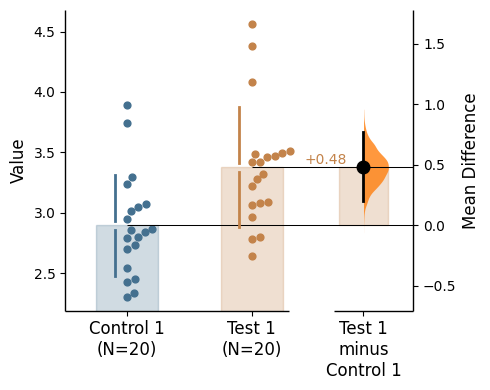

In [ ]:
fig1 = my_data.mean_diff.plot();

 Create a Gardner-Altman plot for the Hedges' g effect size.

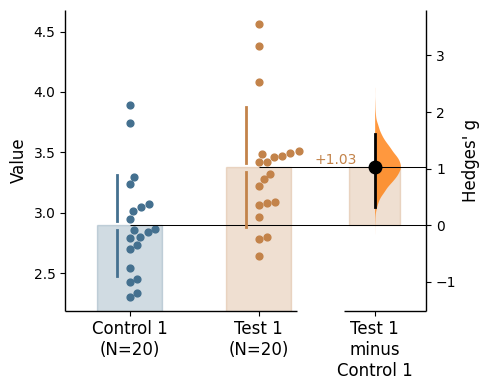

In [ ]:
fig2 = my_data.hedges_g.plot();

Create a Cumming estimation plot for the mean difference.

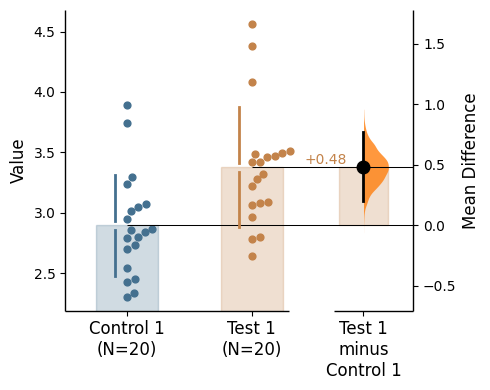

In [ ]:
fig3 = my_data.mean_diff.plot(float_contrast=True);

 Create a paired Gardner-Altman plot.

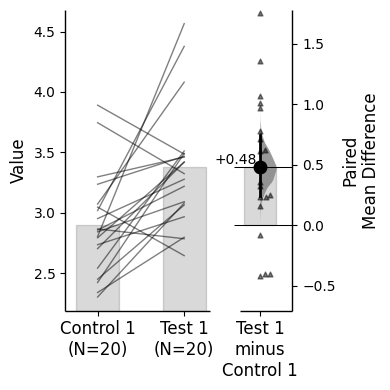

In [ ]:
my_data_paired = dabest.load(df, idx=("Control 1", "Test 1"),
                       id_col = "ID", paired='baseline')
fig4 = my_data_paired.mean_diff.plot();

Create a multi-group Cumming plot.

/Users/jonathananns/GitHub/DABEST-python/dabest/plot_tools.py:2778: UserWarning: 5.0% of the points cannot be placed. You might want to decrease the size of the markers.
  warnings.warn(err)
/Users/jonathananns/GitHub/DABEST-python/dabest/plot_tools.py:2778: UserWarning: 10.0% of the points cannot be placed. You might want to decrease the size of the markers.
  warnings.warn(err)


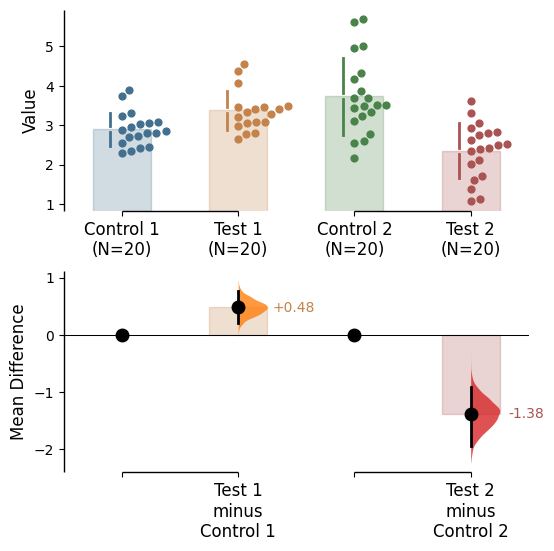

In [ ]:
my_multi_groups = dabest.load(df, id_col = "ID", 
                             idx=(("Control 1", "Test 1"),
                                 ("Control 2", "Test 2")))
fig5 = my_multi_groups.mean_diff.plot();

Create a shared control Cumming plot.

/Users/jonathananns/GitHub/DABEST-python/dabest/plot_tools.py:2778: UserWarning: 10.0% of the points cannot be placed. You might want to decrease the size of the markers.
  warnings.warn(err)


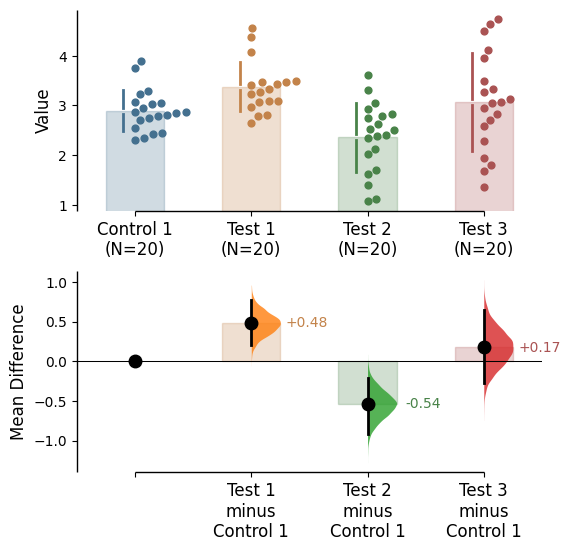

In [ ]:
my_shared_control = dabest.load(df, id_col = "ID",
                                 idx=("Control 1", "Test 1",
                                          "Test 2", "Test 3"))
fig6 = my_shared_control.mean_diff.plot();

Create a repeated meausures (against baseline) Slopeplot.

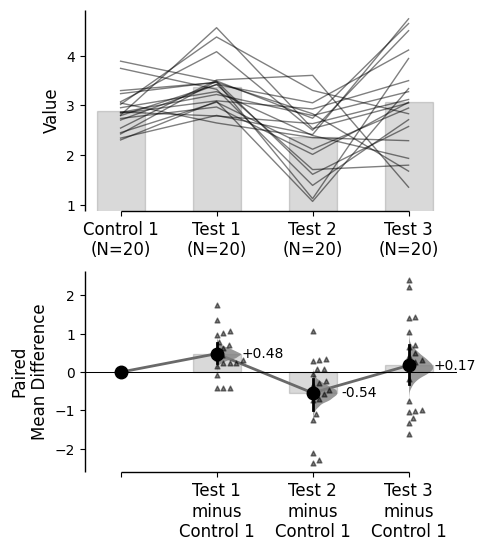

In [ ]:
my_rm_baseline = dabest.load(df, id_col = "ID", paired = "baseline",
                                 idx=("Control 1", "Test 1",
                                          "Test 2", "Test 3"))
fig7 = my_rm_baseline.mean_diff.plot();

Create a repeated meausures (sequential) Slopeplot.

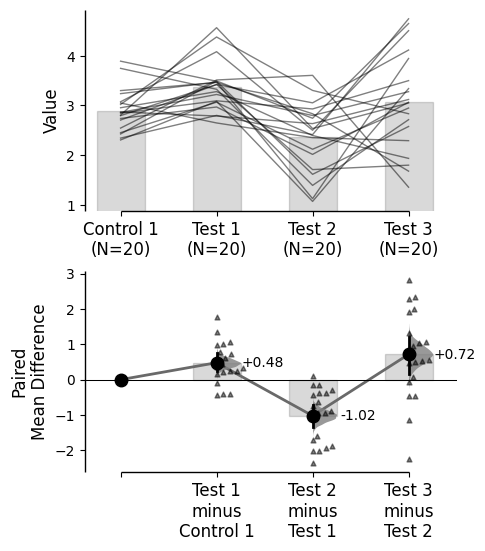

In [ ]:
my_rm_sequential = dabest.load(df, id_col = "ID", paired = "sequential",
                                 idx=("Control 1", "Test 1",
                                          "Test 2", "Test 3"))
fig8 = my_rm_sequential.mean_diff.plot();

In [ ]:
#| export
class PermutationTest:
    """
    A class to compute and report permutation tests.
    
    Parameters
    ----------
    control : array-like
    test : array-like
        These should be numerical iterables.
    effect_size : string.
        Any one of the following are accepted inputs:
        'mean_diff', 'median_diff', 'cohens_d', 'hedges_g', or 'cliffs_delta'
    is_paired : string, default None
    permutation_count : int, default 10000
        The number of permutations (reshuffles) to perform.
    random_seed : int, default 12345
        `random_seed` is used to seed the random number generator during
        bootstrap resampling. This ensures that the generated permutations
        are replicable.
    ps_adjust : bool, default False
        If True, the p-value is adjusted according to Phipson & Smyth (2010).
        # https://doi.org/10.2202/1544-6115.1585

        
    Returns
    -------
    A :py:class:`PermutationTest` object:
        `difference`:float
            The effect size of the difference between the control and the test.
        `effect_size`:string
            The type of effect size reported.
    
    
    """
    
    def __init__(self, control: array,
                 test: array, # These should be numerical iterables.
                 effect_size:str, # Any one of the following are accepted inputs: 'mean_diff', 'median_diff', 'cohens_d', 'hedges_g', or 'cliffs_delta'
                 is_paired:str=None,
                 permutation_count:int=5000, # The number of permutations (reshuffles) to perform.
                 random_seed:int=12345,#`random_seed` is used to seed the random number generator during bootstrap resampling. This ensures that the generated permutations are replicable.
                 ps_adjust:bool=False,
                 **kwargs):
        from ._stats_tools.effsize import two_group_difference
        from ._stats_tools.confint_2group_diff import calculate_group_var
        

        self.__permutation_count = permutation_count

        # Run Sanity Check.
        if is_paired and len(control) != len(test):
            raise ValueError("The two arrays do not have the same length.")

        # Initialise random number generator.
        # rng = random.default_rng(seed=random_seed)
        rng = RandomState(PCG64(random_seed))

        # Set required constants and variables
        control = array(control)
        test = array(test)

        control_sample = control.copy()
        test_sample    = test.copy()

        BAG = array([*control, *test])
        CONTROL_LEN = int(len(control))
        TEST_LEN = int(len(test)) # devMJBL
        EXTREME_COUNT = 0.
        THRESHOLD = abs(two_group_difference(control, test, 
                                                is_paired, effect_size))
        self.__permutations = []
        self.__permutations_var = []

        for i in range(int(self.__permutation_count)):
            if is_paired:
                # Select which control-test pairs to swap.
                random_idx = rng.choice(CONTROL_LEN,
                                rng.randint(0, CONTROL_LEN+1),
                                replace=False)

                # Perform swap.
                for i in random_idx:
                    _placeholder      = control_sample[i]
                    control_sample[i] = test_sample[i]
                    test_sample[i]    = _placeholder
                
            else:
                # Shuffle the bag and assign to control and test groups.
                # NB. rng.shuffle didn't produce replicable results...
                shuffled = rng.permutation(BAG) 
                control_sample = shuffled[:CONTROL_LEN]
                test_sample    = shuffled[CONTROL_LEN:]


            es = two_group_difference(control_sample, test_sample, 
                                    False, effect_size)
            
            group_var = calculate_group_var(var(control_sample, ddof=1), 
                                      CONTROL_LEN, 
                                      var(test_sample, ddof=1), 
                                      len(test_sample))
            self.__permutations.append(es)
            self.__permutations_var.append(group_var)

            if abs(es) > THRESHOLD:
                EXTREME_COUNT += 1.
                
        if ps_adjust:
            # devMJBL
            # adjust calculated p-value according to Phipson & Smyth (2010)
            # https://doi.org/10.2202/1544-6115.1585
            # as per R code in statmod::permp
            # https://rdrr.io/cran/statmod/src/R/permp.R
            # (assumes two-sided test)

            if CONTROL_LEN == TEST_LEN:
                totalPermutations = binomcoeff(CONTROL_LEN + TEST_LEN, TEST_LEN)/2
            else:
                totalPermutations = binomcoeff(CONTROL_LEN + TEST_LEN, TEST_LEN)

            if totalPermutations <= 10e3:
                # use exact calculation
                p = arange(1, totalPermutations + 1)/totalPermutations
                x2 = repeat(EXTREME_COUNT, repeats=totalPermutations)
                Y = binom.cdf(k=x2, n=permutation_count, p=p)
                self.pvalue = mean(Y)
            else:
                # use integral approximation
                def binomcdf(p, k, n):
                    return binom.cdf(k, n, p)

                integrationVal, _ = fixed_quad(binomcdf,
                                            a=0, b=0.5/totalPermutations,
                                            args=(EXTREME_COUNT, permutation_count),
                                            n=128)

                self.pvalue = (EXTREME_COUNT + 1)/(permutation_count + 1) - integrationVal
        else:
            self.pvalue = EXTREME_COUNT / self.__permutation_count
            
        self.__permutations = array(self.__permutations)
        self.__permutations_var = array(self.__permutations_var)

    def __repr__(self):
        return("{} permutations were taken. The p-value is {}.".format(self.__permutation_count, 
                                                                      self.pvalue))


    @property
    def permutation_count(self):
        """
        The number of permuations taken.
        """
        return self.__permutation_count


    @property
    def permutations(self):
        """
        The effect sizes of all the permutations in a list.
        """
        return self.__permutations

    
    @property
    def permutations_var(self):
        """
        The experiment group variance of all the permutations in a list.
        """
        return self.__permutations_var


**Notes**:
    
The basic concept of permutation tests is the same as that behind bootstrapping.
In an "exact" permutation test, all possible resuffles of the control and test 
labels are performed, and the proportion of effect sizes that equal or exceed 
the observed effect size is computed. This is the probability, under the null 
hypothesis of zero difference between test and control groups, of observing the
effect size: the p-value of the Student's t-test.

Exact permutation tests are impractical: computing the effect sizes for all reshuffles quickly exceeds trivial computational loads. A control group and a test group both with 10 observations each would have a total of  $20!$ or $2.43 \times {10}^{18}$ reshuffles.
Therefore, in practice, "approximate" permutation tests are performed, where a sufficient number of reshuffles are performed (5,000 or 10,000), from which the p-value is computed.

More information can be found [here](https://en.wikipedia.org/wiki/Resampling_(statistics)#Permutation_tests).


#### Example: permutation test

In [ ]:
control = norm.rvs(loc=0, size=30, random_state=12345)
test = norm.rvs(loc=0.5, size=30, random_state=12345)
perm_test = dabest.PermutationTest(control, test, 
                                   effect_size="mean_diff", 
                                   is_paired=None)
perm_test

5000 permutations were taken. The p-value is 0.0758.